In [1]:
# import libraries
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

In [2]:
# download the weather time series dataset
zip_path = tf.keras.utils.get_file(
    origin=
    'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
# save the csv dataset as a dataframe
df = pd.read_csv(csv_path)

In [4]:
# examine the data
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
# returns a window of time to train the model on
# history_size = size of the past window of information
# target_size = how far into the future does the model need to learn to predict + the label that needs to be predicted
def single_feature_data(dataset, start_index, end_index, history_size,
                    target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size, ) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [6]:
# Train split
TRAIN_PERCENTAGE = 0.7  # 70%
TRAIN_SPLIT = int(TRAIN_PERCENTAGE * len(df))

In [7]:
# Forecast a single feature time series
# Extract the temperature
one_feature_data = df['T (degC)']
one_feature_data.index = df['Date Time']
# Examine the extracted data
one_feature_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10591c3d0>],
      dtype=object)

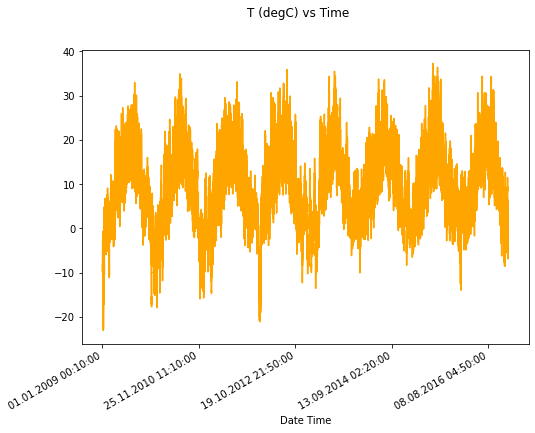

In [8]:
# Observe the data
one_feature_data.plot(subplots=True, color='orange', title='T (degC) vs Time')

In [9]:
# Extract just the temperatures out of the data no date
one_feature_data = one_feature_data.values

In [10]:
# Calculate the data mean and standard deviation
one_feature_data_train_mean = one_feature_data[:TRAIN_SPLIT].mean()
one_feature_data_train_std = one_feature_data[:TRAIN_SPLIT].std()
# Standardize the data
one_feature_data = (one_feature_data -
                    one_feature_data_train_mean) / one_feature_data_train_std

In [11]:
# Create the data for the one feature model
# Model will be given the last 20 recorded temperature observations
# Needs to learn to predict the temperature at the next time step
# Set predict and historical params
ONE_FEATURE_PAST_HISTORY_TO_LEARN_FROM = 20
ONE_FEATURE_FUTURE_TARGET_TO_PREDICT = 0

# uni = one feature
# extract training data
# when just doing blind forecasts the TRAIN_SPLIT below will have to be replaced with 
# TRAIN_SPLIT - 7 to do 7 days into the future
x_train_uni, y_train_uni = single_feature_data(
    one_feature_data, 0, TRAIN_SPLIT, ONE_FEATURE_PAST_HISTORY_TO_LEARN_FROM,
    ONE_FEATURE_FUTURE_TARGET_TO_PREDICT)
# extract validaion data
x_validation_uni, y_validation_uni = single_feature_data(
    one_feature_data, TRAIN_SPLIT, None,
    ONE_FEATURE_PAST_HISTORY_TO_LEARN_FROM,
    ONE_FEATURE_FUTURE_TARGET_TO_PREDICT)

In [12]:
# show the return of single_feature_data
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.97910178]
 [-2.02416646]
 [-2.03572151]
 [-2.01261142]
 [-2.0079894 ]
 [-1.9825683 ]
 [-1.93288159]
 [-1.93288159]
 [-1.96639123]
 [-2.02647747]
 [-2.06460913]
 [-2.07847518]
 [-2.07500867]
 [-2.07269766]
 [-2.05305408]
 [-2.05305408]
 [-2.0576761 ]
 [-2.07038665]
 [-2.07385317]
 [-2.08540821]]

 Target temperature to predict
-2.085408211794277


In [13]:
# create time steps for the plotting
def create_time_steps(length):
    return list(range(-length, 0))

In [14]:
# create a graph to show the training data and the predicted value
def show_plot(plot_data, delta, title):
    labels = ['History', 'Actual Future', 'Predicted Future']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future,
                     plot_data[i],
                     marker[i],
                     markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps,
                     plot_data[i].flatten(),
                     marker[i],
                     label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/Python/.pyenv/versions/3.8.0/lib/python3.8/site-packages/matplotlib/pyplot.py'>

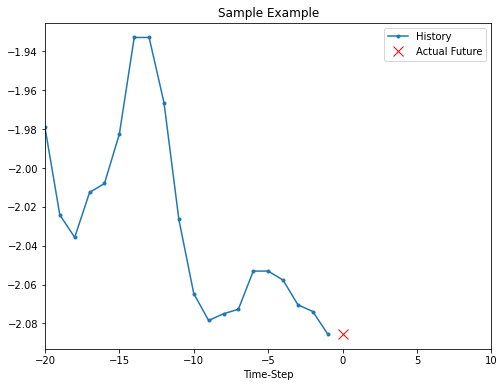

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

# Baseline

In [16]:
# before training the model, set a simple baseline
# given an input the baseline looks at the history 
# and predicts the next point to be the average of the last 20 observations

def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/Python/.pyenv/versions/3.8.0/lib/python3.8/site-packages/matplotlib/pyplot.py'>

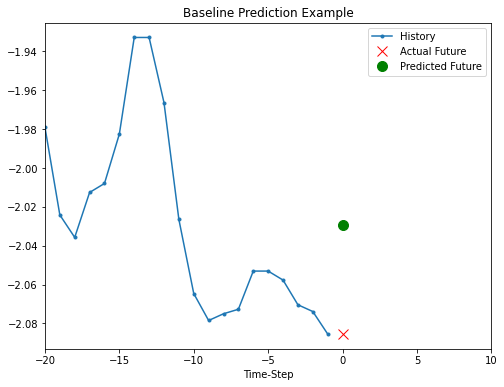

In [17]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

# Recurrent neural network

In [18]:
# shuffle, batch and cache the dataset
BATCH_SIZE = int(len(x_train_uni) / 1149)
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices(
    (x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(
    BATCH_SIZE).repeat()

validation_univariate = tf.data.Dataset.from_tensor_slices(
    (x_validation_uni, y_validation_uni))
validation_univariate = validation_univariate.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [19]:
# setup the lstm network
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

In [20]:
# check the model input and output
for x, y in validation_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [21]:
# EVALUATION_INTERVAL = len(x_train_uni)
EVALUATION_INTERVAL = 1000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation_univariate, validation_steps=50)

Epoch 1/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0664 - val_loss: 0.0020
Epoch 2/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 3/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0013 - val_loss: 8.5687e-04
Epoch 5/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0010 - val_loss: 7.4504e-04
Epoch 6/10
1000/1000 [==============================] - 10s 10ms/step - loss: 8.5375e-04 - val_loss: 6.1411e-04
Epoch 7/10
1000/1000 [==============================] - 10s 10ms/step - loss: 7.5601e-04 - val_loss: 5.6395e-04
Epoch 8/10
1000/1000 [==============================] - 15s 15ms/step - loss: 6.2107e-04 - val_loss: 4.8084e-04
Epoch 9/10
1000/1000 [==============================] - 14s 14ms/step - loss: 5.9817e-04 - val_loss: 4.6753e-04
Epoch 10/10
1000/1000 [=

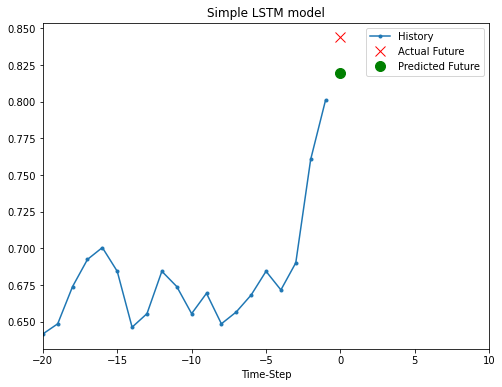

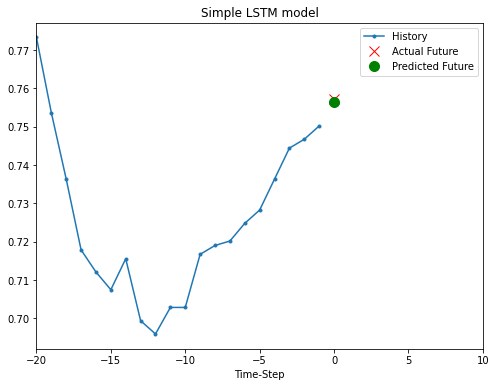

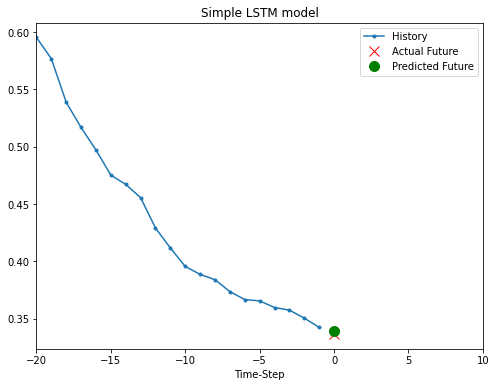

In [22]:
# Predict using the simple lstm model

for x, y in validation_univariate.take(3):
    plot = show_plot(
        [x[0].numpy(), y[0].numpy(),
         simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plt.show()

# Multivariate time series forecast

In [25]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1407fc340>,
      dtype=object)

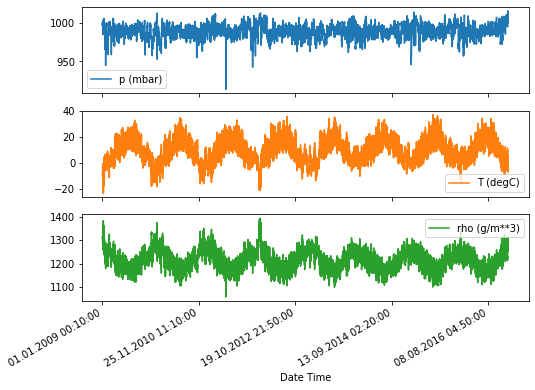

In [26]:
features.plot(subplots=True)

In [28]:
# standardize the dataset using the mean and standard deviation of the training data
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset - data_mean) / data_std

In [29]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [30]:
# network is given data from last 5 days (720 observations)
# future data is 12 hours into the future (12*6) observations are used
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset,
                                                   dataset[:, 1],
                                                   0,
                                                   TRAIN_SPLIT,
                                                   past_history,
                                                   future_target,
                                                   STEP,
                                                   single_step=True)

x_validation_single, y_validation_single = multivariate_data(dataset,
                                                             dataset[:, 1],
                                                             TRAIN_SPLIT,
                                                             None,
                                                             past_history,
                                                             future_target,
                                                             STEP,
                                                             single_step=True)

In [31]:
print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [32]:
# slice up the data
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validation_data_single = tf.data.Dataset.from_tensor_slices((x_validation_single, y_validation_single))
validation_data_single = validation_data_single.batch(BATCH_SIZE).repeat()

In [34]:
# Setup the model, single step multi feature
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

In [35]:
# Sample prediction
for x, y in validation_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [56]:
EVALUATION_INTERVAL = 1000

single_step_history = single_step_model.fit(
    train_data_single,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=validation_data_single,
    validation_steps=50)

Epoch 1/10
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0759 - val_loss: 0.0972
Epoch 2/10
1000/1000 [==============================] - 87s 87ms/step - loss: 0.0764 - val_loss: 0.0939
Epoch 3/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.0747 - val_loss: 0.1302
Epoch 4/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0698 - val_loss: 0.1054
Epoch 5/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0681 - val_loss: 0.1043
Epoch 6/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0669 - val_loss: 0.1185
Epoch 7/10
1000/1000 [==============================] - 73s 73ms/step - loss: 0.0669 - val_loss: 0.1091
Epoch 8/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0646 - val_loss: 0.1040
Epoch 9/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0624 - val_loss: 0.1043
Epoch 10/10
1000/1000 [==============================] - 74s 74m

In [57]:
def plot_train_history(history, title):
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, validation_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

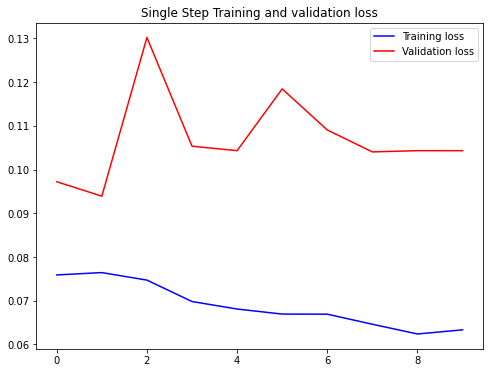

In [58]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

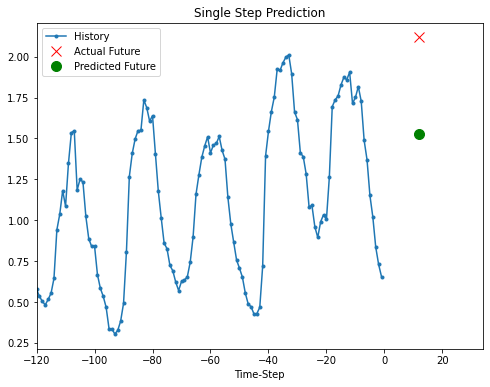

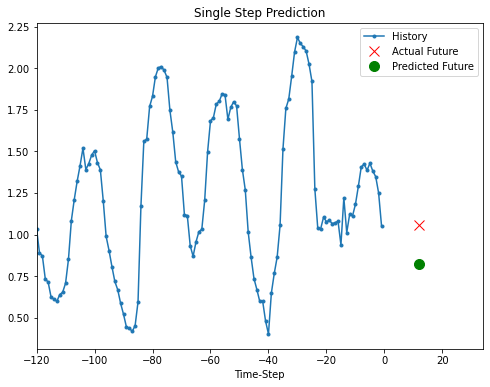

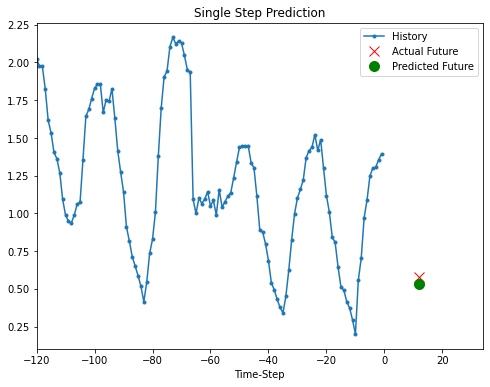

In [59]:
# 12 for 12 hours into the future

for x, y in validation_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 12,
                      'Single Step Prediction')
    plot.show()